LeNet-5 is the first convolutional neural network (interesting read: http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). It was used on large scale to automatically classify hand-written digits on bank cheques in the United States. It is a much simpler architecture compared to today's CNNs. Shown here is the architecture of LeNet, which consists of 2 convolutional layers with sub-sampling layers between them, and 2 fully connected layers. Convolutional layers use 5 by 5 convolutions with stride 1. Sub-sampling layers are 2 by 2 average pooling layers. Tanh sigmoid activations are used throughout the network.
![Lenet-5](img/Lenet.png)
Lets start by training this network for MNIST digit classification. A few imports to begin with:

In [1]:
import gzip
import keras.backend as K
import keras.optimizers as optimizers
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf

from keras.callbacks import ModelCheckpoint, TensorBoard
from keras.layers import (Activation, AveragePooling2D, BatchNormalization, Conv2D, 
                          Dense, Dropout, Flatten, MaxPooling2D)
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras import regularizers
from keras.utils.np_utils import to_categorical
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

%matplotlib inline

/Users/anitha.krishnan/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/anitha.krishnan/miniconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Tensorflow defaultly uses all available GPUs. If training on a multi-gpu system, pick the one to use 

In [4]:
# Function to fetch the images from a url
# https://colab.research.google.com/drive/1CVm50PGE4vhtB5I_a_yc4h5F-itKOVL9#scrollTo=-1pY6ZqJmKJS
from requests import get
def download_file(url, file_name):
    """Get file from the given url
    
    :param str url: url to get data from
    :param str file_name: fname with full path to save the downloaded file
    """
    
    with open(file_name, 'wb') as file:
        response = get(url)
        file.write(response.content)

In [4]:
def read_mnist(images_path, labels_path):
    """Unzip the file and read its contents into a numpy array and reshape to the required shape
    
    :param str image_path: image fpath for the data split
    :param str labels_path: label fpath for the data split
    :return np.array features - 28x28 images and their corresponding labels
    """
    
    with gzip.open(labels_path, 'rb') as labelsFile:
        labels = np.frombuffer(labelsFile.read(), dtype=np.uint8, offset=8)

    with gzip.open(images_path,'rb') as imagesFile:
        length = len(labels)
        # Load flat 28x28 px images (784 px), and convert them to 28x28 px
        features = np.frombuffer(imagesFile.read(), dtype=np.uint8, offset=16) \
                        .reshape(length, 784) \
                        .reshape(length, 28, 28, 1)
        
    return features, labels

In [ ]:
def plot_learning_curve(history):
    """Plot loss and accuracy curve
    
    :param history: Keras object with loss and accuracy for train and val splits
    """
    fig, ax = plt.subplots(1, 2)
    fig.set_size_inches(12, 5)
    ax[0].plot(history.history['acc'])
    ax[0].plot(history.history['val_acc'])
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'val'], loc='upper right')
    
    # summarize history for loss
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'val'], loc='upper right')

In [ ]:
def create_callbacks(model_fpath, log_dir):
    """Create callbacks for training
    
    :param str modle_fpath: fname with full path to save the model weights (.hdf5)
    :param str log_dir: dir to save tensorboard logs
    :return list callbacks: list with ModelCheckPoint and Tensorboard instances
    """
    
    callbacks=[ModelCheckpoint(filepath=model_fpath,
                           mode=min,
                           monitor='val_loss',
                           save_best_only=True,
                           verbose=True),
    TensorBoard(log_dir=log_dir, 
                histogram_freq=0, 
                write_graph=True, 
                write_images=False)]
    return callbacks

In [5]:
mnist_dir = '../data/mnist'
os.makedirs(mnist_dir, exist_ok=True)
download_file('http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz', 
              os.path.join(mnist_dir, 'train-images-idx3-ubyte.gz'))
download_file('http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz', 
              os.path.join(mnist_dir, 'train-labels-idx1-ubyte.gz'))
download_file('http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz', 
              os.path.join(mnist_dir, 't10k-images-idx3-ubyte.gz'))
download_file('http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz', 
              os.path.join(mnist_dir, 't10k-labels-idx1-ubyte.gz'))

In [5]:
imgs_train, labels_train = read_mnist('/home/paperspace/Data/anitha_data/mnist/train-images-idx3-ubyte.gz', 
                                      '/home/paperspace/Data/anitha_data/mnist/train-labels-idx1-ubyte.gz')
imgs_test, labels_test = read_mnist('/home/paperspace/Data/anitha_data/mnist/t10k-images-idx3-ubyte.gz', 
                                    '/home/paperspace/Data/anitha_data/mnist/t10k-labels-idx1-ubyte.gz')
print(len(imgs_train), len(imgs_test))

60000 10000


In [6]:
#Lenet was trained on 32x32 images. Pad images with 0s
imgs_train = np.pad(imgs_train, ((0,0),(2,2),(2,2),(0,0)), 'constant')
imgs_test = np.pad(imgs_test, ((0,0),(2,2),(2,2),(0,0)), 'constant')
    
print("Updated Image Shape: {}".format(imgs_train[0].shape))

Updated Image Shape: (32, 32, 1)


So we have 60k training images and 10k test images. Lets check the distribution of the labels to see if it is unbalanced (their distribution is not close to uniform, there are more samples belonging to one category than the rest). What would happen if the labels are unbalanced?

In [7]:
print([len(np.where(labels_train==lbl)[0]) for lbl in np.unique(labels_train)])

[5923, 6742, 5958, 6131, 5842, 5421, 5918, 6265, 5851, 5949]


Balanced it is! lets split the train set into train and val set, then build our model. Why do you need a validation set?

In [7]:
imgs_train, imgs_val, labels_train, labels_val = train_test_split(imgs_train,
                                                                  labels_train,
                                                                  test_size=0.2, 
                                                                  random_state=0)

In [8]:
train_generator = ImageDataGenerator().flow(imgs_train, to_categorical(labels_train), batch_size=128)
val_generator = ImageDataGenerator().flow(imgs_val, to_categorical(labels_val), batch_size=128)

This is a slighly different version than the original version. We use 'relu' instead of 'tanh' activations. Ignore the additional layers (dropout, batchnorm) for now. We'll come back to it later

In [9]:
def LeNet(num_classes, ip_shape, dropout=0.0, batch_norm=False, reg_const=0.0):
    """LeNet model
    
    :param int num_classes: number of unique classes
    :param list/tuple ip_shape: shape of input to the network (width, height, depth)
    :param float dropout: dropout probability, 0-1
    :param bool batch_norm: flag for including a batch normalization layer
    :param float reg_const: regularization constant
    :return Keras.Model model: Keras model 
    """
    
    model = Sequential()
    # Lenet used valid padding...
    model.add(Conv2D(filters=6, kernel_size=(5, 5), kernel_initializer='he_normal', input_shape=ip_shape))
    if dropout > 0.0:
        model.add(Dropout(rate=dropout))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(filters=16, kernel_size=(5, 5), kernel_initializer='he_normal'))
    if dropout > 0.0:
        model.add(Dropout(rate=dropout))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(AveragePooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())

    model.add(Dense(units=120, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(reg_const))) 
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Activation('relu'))
    
    model.add(Dense(units=84, kernel_initializer='he_normal', kernel_regularizer=regularizers.l2(reg_const)))
    if batch_norm:
        model.add(BatchNormalization())
    model.add(Activation('relu'))

    model.add(Dense(units=num_classes, kernel_initializer='he_normal', activation = 'softmax'))
    return model

In [2]:
gpu_num = 0
gpu_options = tf.GPUOptions(visible_device_list=str(gpu_num))
config = tf.ConfigProto(gpu_options=gpu_options,
                        allow_soft_placement=True,
                        log_device_placement=False)
sess = tf.Session(config=config)
K.set_session(sess)

In [10]:
# we are using Adam. Feel free to experiment with other optimizers
with tf.device('/gpu:{}'.format(gpu_num)):
    model = LeNet(num_classes=10, ip_shape=(32, 32, 1))
opt = optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 6)         156       
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 6)         0         
_________________________________________________________________
average_pooling2d_1 (Average (None, 14, 14, 6)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 10, 10, 16)        2416      
_________________________________________________________________
activation_2 (Activation)    (None, 10, 10, 16)        0         
_________________________________________________________________
average_pooling2d_2 (Average (None, 5, 5, 16)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 400)               0         
__________

In [11]:
callbacks = create_callbacks(model_fpath='/home/paperspace/Data/anitha_data/mnist/mnist_model.hdf5',
                             log_dir='/home/paperspace/Data/anitha_data/mnist/')
with sess.as_default():
    history = model.fit_generator(train_generator,
                                  validation_data=val_generator,
                                  epochs=15, shuffle=True,
                                  callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:408: RuntimeWarning: ModelCheckpoint mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


Epoch 1/15
375/375 [==============================] - 8s 20ms/step - loss: 5.5071 - acc: 0.6233 - val_loss: 2.5064 - val_acc: 0.8162

Epoch 00001: val_loss improved from inf to 2.50637, saving model to ../data/mnist/mnist_model.hdf5
Epoch 2/15
375/375 [==============================] - 4s 11ms/step - loss: 2.3663 - acc: 0.8265 - val_loss: 2.1912 - val_acc: 0.8403

Epoch 00002: val_loss improved from 2.50637 to 2.19121, saving model to ../data/mnist/mnist_model.hdf5
Epoch 3/15
375/375 [==============================] - 4s 10ms/step - loss: 2.1240 - acc: 0.8450 - val_loss: 2.0388 - val_acc: 0.8522

Epoch 00003: val_loss improved from 2.19121 to 2.03885, saving model to ../data/mnist/mnist_model.hdf5
Epoch 4/15
375/375 [==============================] - 4s 10ms/step - loss: 1.9982 - acc: 0.8569 - val_loss: 1.9302 - val_acc: 0.8602

Epoch 00004: val_loss improved from 2.03885 to 1.93022, saving model to ../data/mnist/mnist_model.hdf5
Epoch 5/15
375/375 [==============================] - 4s

In [12]:
score = model.evaluate(imgs_test, to_categorical(labels_test))
print('Test loss:', score[0])
print('Test accuracy:', score[1])

10000/10000 [==============================] - 1s 88us/step
Test loss: 1.749098631515581
Test accuracy: 0.8773


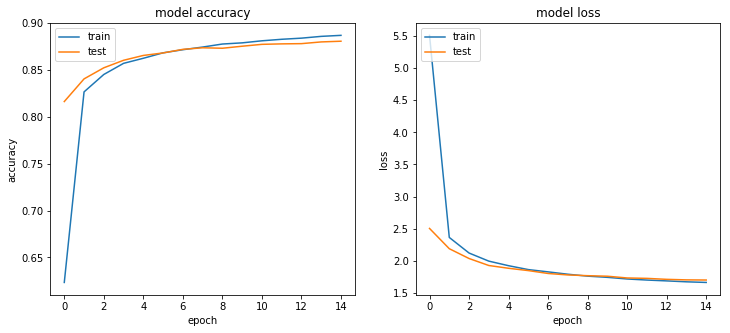

In [13]:
plot_learning_curve(history)

Commonly reported performance metrics: Accuracy, Precision, Recall (Sensitivity, Specificity), F1-score, Confusion mattrix (Recommend the set of lectures and material here: https://developers.google.com/machine-learning/crash-course/classification/precision-and-recall)

In [14]:
y_pred_prob = model.predict(imgs_test)
y_pred = np.argmax(y_pred_prob, axis = 1)
print(accuracy_score(labels_test.astype('int'), y_pred))
print(confusion_matrix(labels_test.astype('int'), y_pred))
print(classification_report(labels_test.astype('int'), y_pred))

0.8773
[[ 972    1    2    0    0    0    0    1    2    2]
 [   2 1123    1    2    0    0    2    2    3    0]
 [   6    3  994   11    0    0    2   11    5    0]
 [   0    0    2 1000    0    4    0    0    2    2]
 [  25    1   25    7    0    1   52  388   47  436]
 [   3    0    0   16    0  859    5    2    5    2]
 [   6    3    4    1    0    3  936    1    4    0]
 [   1    1   13   12    0    0    0  995    2    4]
 [   6    0    1   11    0    8    3    2  935    8]
 [   1    0    1   17    0    5    2   14   10  959]]
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       980
           1       0.99      0.99      0.99      1135
           2       0.95      0.96      0.96      1032
           3       0.93      0.99      0.96      1010
           4       0.00      0.00      0.00       982
           5       0.98      0.96      0.97       892
           6       0.93      0.98      0.96       958
           7       0.70      

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Lets use the same network for a different application and see how it performs. We'll be using the WBC dataset from Kaggle (https://www.kaggle.com/paultimothymooney/blood-cells). The original dataset is highly unbalanced with 206 neutrophils, 88 eosinophils, 33 lymphocytes, 20 monocyte after some clean up and removing one category which had only 3 samples. Fortunately, we are provided with another set with equal representation from all classes obtained by augmenting the original images. (Image augmentation is not ideal, but should be ok for our example here). Download the dataset2-master folder and place it in '../data/wbc'

In [ ]:
from keras import applications
from keras.models import Model

In [4]:
img_dir = '/home/paperspace/Data/anitha_data/wbc'
target_shape = [120, 160]

def get_train_val_gen(target_shape, batch_size):
    train_datagen = ImageDataGenerator(
        rescale= 1./255, 
        vertical_flip=True,
        horizontal_flip=True)
    train_generator = train_datagen.flow_from_directory(
        os.path.join(img_dir, 'TRAIN'),
        target_size=(target_shape[0], target_shape[1]),
        batch_size=batch_size,
        class_mode='categorical')

    val_datagen = ImageDataGenerator(rescale= 1./255)
    val_generator = val_datagen.flow_from_directory(
        os.path.join(img_dir, 'TEST'),
        target_size=(target_shape[0], target_shape[1]),
        batch_size=batch_size,
        class_mode='categorical')
    return train_generator, val_generator

train_generator, val_generator = get_train_val_gen(target_shape, 128)

Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.


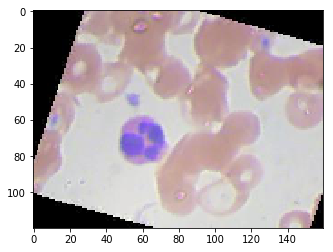

In [15]:
tr_imgs, tr_y = train_generator.next()
plt.imshow(tr_imgs[0])

In [20]:
opt = optimizers.Adam(lr=0.0001)
with tf.device('/gpu:{}'.format(gpu_num)):
    model = LeNet(num_classes=4, ip_shape=(120, 160, 3))
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_5 (Conv2D)            (None, 116, 156, 6)       456       
_________________________________________________________________
activation_9 (Activation)    (None, 116, 156, 6)       0         
_________________________________________________________________
average_pooling2d_5 (Average (None, 58, 78, 6)         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 54, 74, 16)        2416      
_________________________________________________________________
activation_10 (Activation)   (None, 54, 74, 16)        0         
_________________________________________________________________
average_pooling2d_6 (Average (None, 27, 37, 16)        0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 15984)             0         
__________

In [21]:
callbacks = create_callbacks(model_fpath='/home/paperspace/Data/anitha_data/wbc/wbc_class_pred_model.hdf5',
                             log_dir='/home/paperspace/Data/anitha_data/wbc')
with sess.as_default():
    history = model.fit_generator(train_generator,
                                  validation_data=val_generator,
                                  epochs=15, shuffle=True,
                                  callbacks=callbacks)

Epoch 1/15
78/78 [==============================] - 59s 761ms/step - loss: 1.3882 - acc: 0.2629 - val_loss: 1.3765 - val_acc: 0.3550

Epoch 00001: val_loss improved from inf to 1.37651, saving model to ../data/wbc/wbc_class_pred_model.hdf5
Epoch 2/15
78/78 [==============================] - 50s 643ms/step - loss: 1.3301 - acc: 0.3716 - val_loss: 1.2556 - val_acc: 0.4041

Epoch 00002: val_loss improved from 1.37651 to 1.25564, saving model to ../data/wbc/wbc_class_pred_model.hdf5
Epoch 3/15
78/78 [==============================] - 50s 647ms/step - loss: 1.2213 - acc: 0.4327 - val_loss: 1.2061 - val_acc: 0.3949

Epoch 00003: val_loss improved from 1.25564 to 1.20613, saving model to ../data/wbc/wbc_class_pred_model.hdf5
Epoch 4/15
78/78 [==============================] - 50s 645ms/step - loss: 1.1522 - acc: 0.4822 - val_loss: 1.1686 - val_acc: 0.4503

Epoch 00004: val_loss improved from 1.20613 to 1.16863, saving model to ../data/wbc/wbc_class_pred_model.hdf5
Epoch 5/15
78/78 [==========

In a CNN, convolution layers are compute intensive i.e. affect the training / inference time, while the fully connected layers are parameters dense i.e. affect the model size drastically. Check out VGG model here (http://cs231n.github.io/convolutional-networks/) and which layer contributes the most number of parameters? There is so much redundancy in these layers that you could throw out 80-90% of it selectively after training. Why this preamble.. Just with base Lenet u should have got an accuracy of ~75% on train set and ~0.65 on the val set. Change the network architecture to increase val accuracy to >0.9. Try:
1) adding more filters
2) adding more layers / removing layers
3) increasing the number of neurons in the fully connected layers

In [11]:
train_generator, val_generator = get_train_val_gen((240, 240, 3), 32)

# model = applications.ResNet50(weights='imagenet', include_top=False, input_shape = (240, 240, 3))
model = applications.vgg16.VGG16(weights='imagenet', include_top=False, input_shape = (240, 240, 3))
#Adding custom Layers 
x = model.output
x = Flatten()(x)
x = Dense(64, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(16, activation="relu")(x)
predictions = Dense(4, activation="softmax")(x)

# creating the final model 
with tf.device('/gpu:{}'.format(gpu_num)):
    model_final = Model(input = model.input, output = predictions)


# compile the model 
model_final.compile(loss='categorical_crossentropy', 
                    optimizer=optimizers.SGD(lr=0.0001, momentum=0.9), 
                    metrics=["accuracy"])


Found 9957 images belonging to 4 classes.
Found 2487 images belonging to 4 classes.
58892288/58889256 [==============================] - 5s 0us/step


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:18: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`


In [12]:
model_final.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 240, 240, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0         
__________

In [13]:
callbacks = create_callbacks(model_fpath='/home/paperspace/Data/anitha_data/wbc/wbc_vgg_model.hdf5',
                             log_dir='/home/paperspace/Data/anitha_data/wbc')

with sess.as_default():
    history = model_final.fit_generator(train_generator,
                                  validation_data=val_generator,
                                  epochs=15, shuffle=True,
                                  callbacks=callbacks)

/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:408: RuntimeWarning: ModelCheckpoint mode <built-in function min> is unknown, fallback to auto mode.
  RuntimeWarning)


Epoch 1/15
312/312 [==============================] - 101s 323ms/step - loss: 1.3872 - acc: 0.2733 - val_loss: 1.3729 - val_acc: 0.2815

Epoch 00001: val_loss improved from inf to 1.37286, saving model to ../data/wbc/wbc_vgg_model.hdf5
Epoch 2/15
312/312 [==============================] - 100s 321ms/step - loss: 1.3480 - acc: 0.3176 - val_loss: 1.2316 - val_acc: 0.3916

Epoch 00002: val_loss improved from 1.37286 to 1.23163, saving model to ../data/wbc/wbc_vgg_model.hdf5
Epoch 3/15
312/312 [==============================] - 101s 324ms/step - loss: 1.1243 - acc: 0.4571 - val_loss: 0.9908 - val_acc: 0.4994

Epoch 00003: val_loss improved from 1.23163 to 0.99084, saving model to ../data/wbc/wbc_vgg_model.hdf5
Epoch 4/15
312/312 [==============================] - 100s 321ms/step - loss: 0.9387 - acc: 0.5608 - val_loss: 0.8752 - val_acc: 0.5565

Epoch 00004: val_loss improved from 0.99084 to 0.87516, saving model to ../data/wbc/wbc_vgg_model.hdf5
Epoch 5/15
312/312 [========================

In [7]:
model_final.load_weights('/home/paperspace/Data/anitha_data/wbc/wbc_class_pred_model.hdf5')

In [8]:
test_datagen = ImageDataGenerator(rescale= 1./255)
test_generator = test_datagen.flow_from_directory(
        os.path.join(img_dir, 'TEST_SIMPLE'),
        target_size=(240, 240),
        batch_size=32,
        class_mode='categorical')
model_final.evaluate_generator(test_generator)

Found 71 images belonging to 4 classes.


[0.2819991107557861, 0.8873239445014739]